## Install Qiskit

In [1]:
!pip install qiskit qiskit-aer --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 7.8 MB/s eta 0:00:00


## Setup MLflow

MLflow is a tool for tracking machine learning experiments.

In [ ]:
!pip install mlflow --quiet

In [3]:
import mlflow

In [4]:
mlflow.autolog()
mlflow.set_experiment("QuantumJourney")

2023/10/01 08:29:41 INFO mlflow.tracking.fluent: Experiment with name 'QuantumJourney' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/824973383822689326', creation_time=1696148981791, experiment_id='824973383822689326', last_update_time=1696148981791, lifecycle_stage='active', name='QuantumJourney', tags={}>

## Setup device

In [5]:
import torch

In [6]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


## Implement Qiskit random number generator

We utilize Qiskit to generate (potentially) truly random numbers.

In [7]:
from qiskit import QuantumCircuit, Aer, execute
from typing import List

In [8]:
NUMBER_OF_QUBITS = 8

In [9]:
qc = QuantumCircuit(NUMBER_OF_QUBITS)

for qubit in range(NUMBER_OF_QUBITS):
    qc.h(qubit)

qc.measure_all()

In [10]:
def quantum_rand(samples: int) -> List[float]:

    backend_sim = Aer.get_backend('aer_simulator')

    job_sim = execute(qc, backend_sim, shots=samples, memory=True)

    result_sim = job_sim.result()
    memory = result_sim.get_memory()

    output = []
    for bin_str in memory:
      float_value = sum(int(bit) * 2**-(idx+1) for idx, bit in enumerate(bin_str))
      output.append(float_value)

    return output

In [11]:
def quantum_rand_like(tensor: torch.Tensor) -> torch.Tensor:
    random_floats = quantum_rand(tensor.numel())

    return torch.Tensor(random_floats).view(tensor.shape).to(device)

## Download data

In [12]:
!mkdir /root/.kaggle

In [13]:
!cp drive/MyDrive/kaggle/kaggle.json /root/.kaggle/kaggle.json

In [14]:
!kaggle datasets download -d crawford/cat-dataset

100% 4.03G/4.04G [00:44<00:00, 103MB/s]
100% 4.04G/4.04G [00:44<00:00, 97.3MB/s]


In [15]:
!unzip cat-dataset.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: cats/CAT_05/00001130_020.jpg  
  inflating: cats/CAT_05/00001130_020.jpg.cat  
  inflating: cats/CAT_05/00001130_023.jpg  
  inflating: cats/CAT_05/00001130_023.jpg.cat  
  inflating: cats/CAT_05/00001130_026.jpg  
  inflating: cats/CAT_05/00001130_026.jpg.cat  
  inflating: cats/CAT_05/00001131_003.jpg  
  inflating: cats/CAT_05/00001131_003.jpg.cat  
  inflating: cats/CAT_05/00001131_026.jpg  
  inflating: cats/CAT_05/00001131_026.jpg.cat  
  inflating: cats/CAT_05/00001132_007.jpg  
  inflating: cats/CAT_05/00001132_007.jpg.cat  
  inflating: cats/CAT_05/00001132_008.jpg  
  inflating: cats/CAT_05/00001132_008.jpg.cat  
  inflating: cats/CAT_05/00001132_014.jpg  
  inflating: cats/CAT_05/00001132_014.jpg.cat  
  inflating: cats/CAT_05/00001132_017.jpg  
  inflating: cats/CAT_05/00001132_017.jpg.cat  
  inflating: cats/CAT_05/00001132_018.jpg  
  inflating: cats/CAT_05/00001132_018.jpg.cat  
  inflating: ca

## Prepare data

In [16]:
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

2023/10/01 08:31:34 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [17]:
def get_all_images(root_dir):
    image_files = []
    for foldername, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith('.jpg'):
                image_files.append(os.path.join(foldername, filename))
    return image_files

In [18]:
class CatDataset(Dataset):
    def __init__(self, image_files, transform=None):
        self.image_files = image_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image

In [19]:
root_dir = '/content/cats'
image_files = get_all_images(root_dir)

In [20]:
train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)

In [21]:
IMAGE_SIZE = 56
mlflow.log_param('image_size', IMAGE_SIZE)

56

In [22]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()])

In [23]:
train_dataset = CatDataset(train_files, transform=transform)
test_dataset = CatDataset(test_files, transform=transform)

In [24]:
batch_size = 256
mlflow.log_param('batch_size', batch_size)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)

In [25]:
def get_train_images(num):
    return torch.stack([train_dataset[i] for i in range(0,0+num)], dim=0)

## Implement Variational Autoencoder

Variational Autoencoder (VAE) is a type of autoencoder in which new creations are generated by random sampling from the latent space - we've decided to use quantum for that.

In [26]:
import torch.nn as nn
import torch.nn.functional as F

In [27]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean  = nn.Linear(hidden_dim, latent_dim)
        self.fc_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        x = torch.flatten(x, 1)
        x       = self.LeakyReLU(self.fc_1(x))
        x       = self.LeakyReLU(self.fc_2(x))

        mean     = self.fc_mean(x)
        log_var  = self.fc_var(x)

        return mean, log_var

In [28]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))

        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 3, IMAGE_SIZE, IMAGE_SIZE])
        return x_hat

In [29]:
def vae_loss_function(x, x_hat, mean, log_var):
    batch_size = x.size(0)

    reconstruction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum') / batch_size

    kld = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()) / batch_size

    total_loss = reconstruction_loss + kld

    return total_loss

In [30]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim=input_dim)


    def reparameterization(self, mean, var):
        std = torch.exp(0.5 * var)
        epsilon = quantum_rand_like(std)
        z = mean + epsilon * std  # Reparameterization trick
        return z


    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

## Create the model

In [31]:
mlflow.start_run()

In [32]:
latent_dim=32
mlflow.log_param('latent_dim', latent_dim)
hidden_dim=1024
mlflow.log_param('hidden_dim', hidden_dim)

1024

In [33]:
vae = VAE(latent_dim=latent_dim, hidden_dim=hidden_dim, input_dim=IMAGE_SIZE*IMAGE_SIZE*3).to(device)

## Train the model

In [34]:
import torch.optim as optim
import numpy as np

In [35]:
learning_rate=0.001
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
mlflow.log_param('learning_rate', learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [36]:
num_epochs = 30
for n in range(num_epochs):
    losses_epoch = []
    for x in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var)
        losses_epoch.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    L1_list = []
    for x in iter(test_loader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    epoch_loss = np.mean(np.array(losses_epoch))
    L1_loss = np.mean(L1_list)
    print(f"Epoch {n} loss {epoch_loss}, test L1 = {L1_loss}")
    mlflow.log_param(f'epoch_{n}_loss', epoch_loss)
    mlflow.log_param(f'L1_{n}_loss', L1_loss)
    scheduler.step()

Epoch 0 loss 6398.557052612305, test L1 = 0.1934888642281294
Epoch 1 loss 6007.100982666016, test L1 = 0.16567680053412914
Epoch 2 loss 5822.634536743164, test L1 = 0.1496817022562027
Epoch 3 loss 5742.631988525391, test L1 = 0.14791722409427166
Epoch 4 loss 5724.430755615234, test L1 = 0.14305100962519646
Epoch 5 loss 5662.109161376953, test L1 = 0.13770150393247604
Epoch 6 loss 5637.0784912109375, test L1 = 0.1364868301898241
Epoch 7 loss 5622.643661499023, test L1 = 0.13500683568418026
Epoch 8 loss 5586.732345581055, test L1 = 0.12948538549244404
Epoch 9 loss 5565.085632324219, test L1 = 0.12782811746001244
Epoch 10 loss 5552.595153808594, test L1 = 0.12688895128667355
Epoch 11 loss 5542.911041259766, test L1 = 0.12705999985337257
Epoch 12 loss 5534.132385253906, test L1 = 0.12256140448153019
Epoch 13 loss 5512.753860473633, test L1 = 0.12177817337214947
Epoch 14 loss 5509.44709777832, test L1 = 0.12180651817470789
Epoch 15 loss 5501.9029541015625, test L1 = 0.11982688680291176
Epoc

## Visualize images

In [37]:
import matplotlib.pyplot as plt
import torchvision

In [38]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()

    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

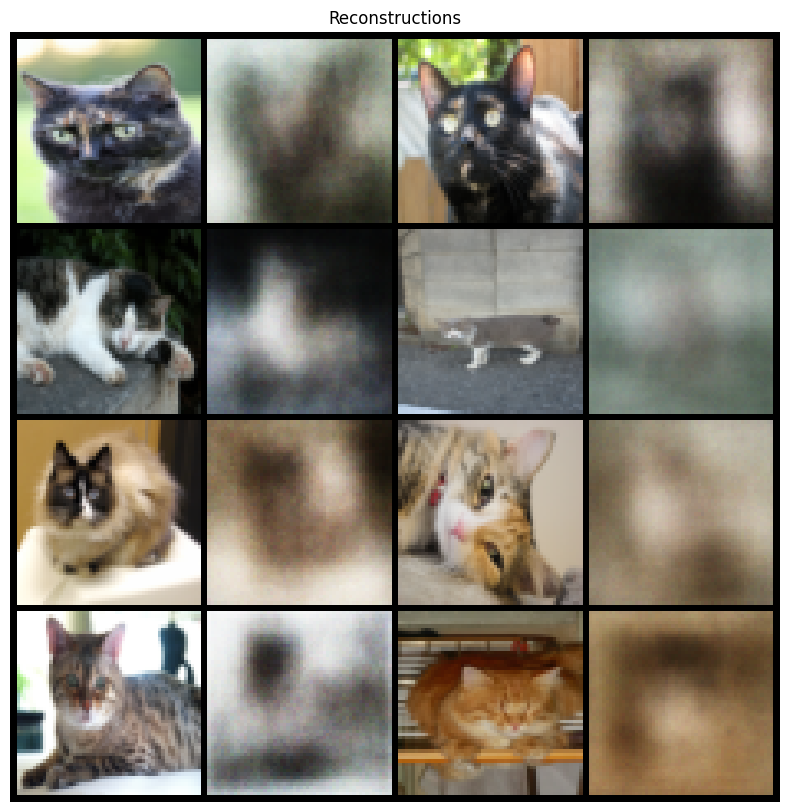

In [39]:
input_imgs = get_train_images(8)
visualize_reconstructions(vae, input_imgs, device)

In [40]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device))
    generated_imgs = generated_imgs.cpu()

    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

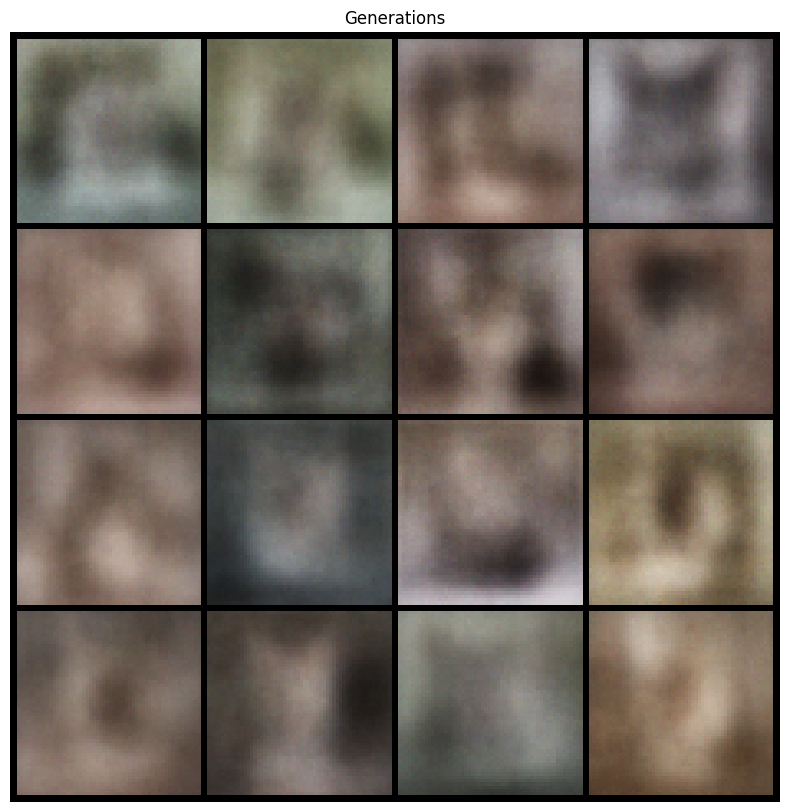

In [41]:
generate_images(vae, 16, device)

## Save the model

In [42]:
from datetime import datetime

In [43]:
filename = f'vae_conv_{IMAGE_SIZE}_{datetime.now().strftime("%H%M%S%d%m%Y")}'

In [44]:
torch.save(vae.state_dict(), f'/content/drive/MyDrive/HackYeah2023/{filename}')

In [45]:
mlflow.end_run()